In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from numpy.random import RandomState
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch.nn as nn
import torch
import torch.optim as optim
from tqdm import tqdm
from torch.nn import Linear, CrossEntropyLoss
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/unseen-algorithm/Algos.csv
/kaggle/input/unseen-algorithm/AlgosVersion2.csv


In [2]:
try:
    shutil.rmtree("/kaggle/working/model_path")
except:
    print('Nothing to Delete')

Nothing to Delete


## Importing data from CSV file.

In [3]:
df = pd.read_csv('/kaggle/input/unseen-algorithm/AlgosVersion2.csv')
df

,Algorithm,Method,AST,AAST
0,DijkstraAlgorithm,Hash-Map-1,CompilationUnit(imports=[Import(path=java.util...,"{'imports': [{'path': 'java.util.HashMap', 'st..."
1,DijkstraAlgorithm,Hash-Map-2,CompilationUnit(imports=[Import(path=java.util...,"{'imports': [{'path': 'java.util.HashMap', 'st..."
2,DijkstraAlgorithm,Hash-Map-3,CompilationUnit(imports=[Import(path=java.util...,"{'imports': [{'path': 'java.util.HashMap', 'st..."
3,DijkstraAlgorithm,Hash-Map-4,CompilationUnit(imports=[Import(path=java.util...,"{'imports': [{'path': 'java.util.HashMap', 'st..."
4,DijkstraAlgorithm,Hash-Map-5,CompilationUnit(imports=[Import(path=java.util...,"{'imports': [{'path': 'java.util.HashMap', 'st..."
...,...,...,...,...
105,NewtonRaphsonMethod,While-5,"CompilationUnit(imports=[], package=None, type...",{'types': [{'body': [{'body': [{'type': 'doubl...
106,NewtonRaphsonMethod,While-6,"CompilationUnit(imports=[], package=None, type...",{'types': [{'body': [{'body': [{'type': 'doubl...
107,NewtonRaphsonMethod,While-7,"CompilationUnit(imports=[], package=None, type...",{'types': [{'body': [{'body': [{'type': 'doubl...
108,NewtonRaphsonMethod,While-8,"CompilationUnit(imports=[], package=None, type...",{'types': [{'body': [{'body': [{'type': 'doubl...


### Unique Algorithms/Labels in the Dataset

In [4]:
df['Algorithm'].unique()

array(['DijkstraAlgorithm', 'EulerMethod', 'JacobiAlgorithm', 'KMeans',
       'NewtonRaphsonMethod'], dtype=object)

### Label Decleration

In [5]:
label = {'DijkstraAlgorithm': 0, 'EulerMethod': 1, 'JacobiAlgorithm': 2, 'KMeans': 3,
       'NewtonRaphsonMethod': 4}

### Corresponding Integer Label

In [6]:
arr = []
for i in range(0,110):
    arr.append(label[df['Algorithm'][i]])
df['Labels'] = arr

### Dropping Useless columns

In [7]:
df = df.drop(columns=['Method','Algorithm'],axis = 1)
df

,AST,AAST,Labels
0,CompilationUnit(imports=[Import(path=java.util...,"{'imports': [{'path': 'java.util.HashMap', 'st...",0
1,CompilationUnit(imports=[Import(path=java.util...,"{'imports': [{'path': 'java.util.HashMap', 'st...",0
2,CompilationUnit(imports=[Import(path=java.util...,"{'imports': [{'path': 'java.util.HashMap', 'st...",0
3,CompilationUnit(imports=[Import(path=java.util...,"{'imports': [{'path': 'java.util.HashMap', 'st...",0
4,CompilationUnit(imports=[Import(path=java.util...,"{'imports': [{'path': 'java.util.HashMap', 'st...",0
...,...,...,...
105,"CompilationUnit(imports=[], package=None, type...",{'types': [{'body': [{'body': [{'type': 'doubl...,4
106,"CompilationUnit(imports=[], package=None, type...",{'types': [{'body': [{'body': [{'type': 'doubl...,4
107,"CompilationUnit(imports=[], package=None, type...",{'types': [{'body': [{'body': [{'type': 'doubl...,4
108,"CompilationUnit(imports=[], package=None, type...",{'types': [{'body': [{'body': [{'type': 'doubl...,4


### Changing the sequence

In [8]:
df = df.sample(frac=1).reset_index(drop=True)
df

,AST,AAST,Labels
0,"CompilationUnit(imports=[], package=None, type...",{'types': [{'body': [{'body': [{'type': 'doubl...,4
1,"CompilationUnit(imports=[], package=None, type...",{'types': [{'body': [{'body': [{'type': 'doubl...,4
2,"CompilationUnit(imports=[], package=None, type...",{'types': [{'body': [{'body': [{'type': 'doubl...,4
3,"CompilationUnit(imports=[], package=None, type...",{'types': [{'body': [{'body': [{'type': 'doubl...,4
4,"CompilationUnit(imports=[], package=None, type...",{'types': [{'body': [{'body': [{'type': 'doubl...,1
...,...,...,...
105,"CompilationUnit(imports=[], package=None, type...",{'types': [{'body': [{'body': [{'type': 'doubl...,1
106,"CompilationUnit(imports=[], package=None, type...",{'types': [{'body': [{'body': [{'type': 'doubl...,1
107,CompilationUnit(imports=[Import(path=java.util...,"{'imports': [{'path': 'java.util.ArrayList', '...",3
108,CompilationUnit(imports=[Import(path=java.util...,"{'imports': [{'path': 'java.util.HashMap', 'st...",0


### Creating Validation Set with atleast one implementation of every Algorithm

In [9]:
while True:
    trainntest_df, val_df = train_test_split(df, test_size=0.1, random_state=RandomState())
    print("Training Data Shape: \n" , trainntest_df.shape, "\nUnique Labels: \n",trainntest_df['Labels'].unique())
    print("Validation Data Shape: \n" , val_df.shape, "\nUnique Labels: \n",val_df['Labels'].unique())
    # Checking If there are all types of algorithms in the validation set; if not resplit.  
    if len(val_df['Labels'].unique()) == len(trainntest_df['Labels'].unique()):
        break
    else:
        print('Validation Dataset has some missing Labels. Thus splitting again.')

Training Data Shape: 
 (99, 3) 
Unique Labels: 
 [2 4 0 1 3]
Validation Data Shape: 
 (11, 3) 
Unique Labels: 
 [2 0 1 4]
Validation Dataset has some missing Labels. Thus splitting again.
Training Data Shape: 
 (99, 3) 
Unique Labels: 
 [4 1 2 0 3]
Validation Data Shape: 
 (11, 3) 
Unique Labels: 
 [4 0 1 3]
Validation Dataset has some missing Labels. Thus splitting again.
Training Data Shape: 
 (99, 3) 
Unique Labels: 
 [1 3 4 2 0]
Validation Data Shape: 
 (11, 3) 
Unique Labels: 
 [1 2 3 4]
Validation Dataset has some missing Labels. Thus splitting again.
Training Data Shape: 
 (99, 3) 
Unique Labels: 
 [0 4 2 1 3]
Validation Data Shape: 
 (11, 3) 
Unique Labels: 
 [1 3 4 2]
Validation Dataset has some missing Labels. Thus splitting again.
Training Data Shape: 
 (99, 3) 
Unique Labels: 
 [3 4 1 2 0]
Validation Data Shape: 
 (11, 3) 
Unique Labels: 
 [1 4 3 0]
Validation Dataset has some missing Labels. Thus splitting again.
Training Data Shape: 
 (99, 3) 
Unique Labels: 
 [1 3 0 4 2]

### Creating Test Set with atleast one implementation of every Algorithm

In [10]:
while True:
    train_df, test_df = train_test_split(trainntest_df, test_size=0.1, random_state=RandomState())
    print("Training Data Shape: \n" , train_df.shape, "\nUnique Labels: \n",train_df['Labels'].unique())
    print("Testing Data Shape: \n" , test_df.shape, "\nUnique Labels: \n",test_df['Labels'].unique())
    # Checking If there are all types of algorithms in the validation set; if not resplit.  
    if len(test_df['Labels'].unique()) == len(train_df['Labels'].unique()):
        break
    else:
        print('Test Dataset has some missing Labels. Thus splitting again.')

Training Data Shape: 
 (89, 3) 
Unique Labels: 
 [1 4 2 3 0]
Testing Data Shape: 
 (10, 3) 
Unique Labels: 
 [4 2 3 1]
Test Dataset has some missing Labels. Thus splitting again.
Training Data Shape: 
 (89, 3) 
Unique Labels: 
 [1 3 2 4 0]
Testing Data Shape: 
 (10, 3) 
Unique Labels: 
 [4 3 1 2]
Test Dataset has some missing Labels. Thus splitting again.
Training Data Shape: 
 (89, 3) 
Unique Labels: 
 [3 1 4 0 2]
Testing Data Shape: 
 (10, 3) 
Unique Labels: 
 [0 1 2 4]
Test Dataset has some missing Labels. Thus splitting again.
Training Data Shape: 
 (89, 3) 
Unique Labels: 
 [4 1 0 3 2]
Testing Data Shape: 
 (10, 3) 
Unique Labels: 
 [1 4 0]
Test Dataset has some missing Labels. Thus splitting again.
Training Data Shape: 
 (89, 3) 
Unique Labels: 
 [1 0 3 4 2]
Testing Data Shape: 
 (10, 3) 
Unique Labels: 
 [1 4 3 0]
Test Dataset has some missing Labels. Thus splitting again.
Training Data Shape: 
 (89, 3) 
Unique Labels: 
 [3 1 2 4 0]
Testing Data Shape: 
 (10, 3) 
Unique Labels: 

### Resetting index of datframes for uninterrupted iteration

In [11]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [12]:
train = pd.DataFrame.to_numpy(train_df)
val = pd.DataFrame.to_numpy(val_df)
test = pd.DataFrame.to_numpy(test_df)
print(len(train),len(val),len(test))

89 11 10


### Initializing Tokenizer

In [13]:
tokenizer = AutoTokenizer.from_pretrained('huggingface/CodeBERTa-small-v1')

### Declaring Dataset class

In [14]:
class datasetClass(Dataset):
    def __init__(self, element):
        input_ids = []
        attn_masks = []

        for index in range(len(element)):
            temp = tokenizer(element[index, 0], element[index,1], padding='max_length', truncation=True, return_tensors='pt')
            input_ids.append(temp['input_ids'])
            attn_masks.append(temp['attention_mask'])

        self.input_ids = torch.cat(input_ids, out=torch.Tensor(len(input_ids), 512)).type(torch.LongTensor)
        self.attn_masks = torch.cat(attn_masks, out=torch.Tensor(len(attn_masks), 512)).type(torch.LongTensor)
        self.labels =  torch.from_numpy(element[:, 2].astype(int))
      
    def __getitem__(self, index):
        return self.input_ids[index], self.attn_masks[index], self.labels[index]

    def __len__(self):
        return len(self.labels)

### Initializing each dataset class with corresponding data

In [15]:
train_dataset = datasetClass(train)
val_dataset = datasetClass(val)
test_dataset = datasetClass(test)

In [16]:
# Declaring batch size
batch_size = 4

### Defining DataLoaders

In [17]:
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

### Model Defination

In [18]:
model_name = "huggingface/CodeBERTa-small-v1"
model = AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=False, num_labels=5)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Using Cross Entropy to Claculate Loss

In [19]:
loss_fn = torch.nn.CrossEntropyLoss()

In [20]:
def accuracy_loss(device, total_logits, labels_for_loss, pred, true):
    correct = 0
    count = 0
    total_loss = 0
    num_batch = 0
    for i in range(len(pred)):
        pred_i = pred[i]
        true_i = true[i]
        
        correct += np.sum(pred_i == true_i)
        total_loss += loss_fn(total_logits[i].to('cpu'), labels_for_loss[i].to('cpu').float())

        count += len(pred_i)
        num_batch += 1
    print(' Correct',correct,'count',count)
    acc = correct/count
    loss = total_loss/num_batch

    return correct, total_loss, count, num_batch, acc, loss

In [21]:

def calc_perf(model, device, data_loader):
    total_logits, labels_for_loss, predictions, true_labels = [], [], [], []

    for batch in data_loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        label_ids = b_labels

        activation = nn.Softmax(dim=1)
        logits = activation(logits)

        # Assuming 5 classes, modify this accordingly
        # Calculate logits and predictions for each class
        tmp_logits = torch.max(logits, dim=1)
        logits = torch.abs(tmp_logits.values.sum() - tmp_logits.values)
        pred = tmp_logits.indices

        pred = pred.detach().cpu().numpy()

        total_logits.append(logits)
        labels_for_loss.append(label_ids)
        predictions.append(pred)
        true_labels.append(label_ids.to('cpu').numpy())

    correct, total_loss, count, num_batch, acc, loss = accuracy_loss(device, total_logits, labels_for_loss, predictions, true_labels)

    return acc, round(float(loss), 4)


In [22]:
# Assigning GPU to device if available 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initializing optimizer
optimizer = torch.optim.AdamW(model.parameters(),lr = 8e-6,eps = 1e-8)

# Declaring total epochs
num_epochs = 10
step_count = 0
# Total step count 
total_steps = num_epochs * len(train_loader)

model = model.to(device)

train_acc = []
valid_acc = []
train_loss = []
valid_loss = []
valid_loss_min = 10.0

loss_over_10_steps = []

model_path = '/kaggle/working/models/'
saved_at_step = 0

for epoch in tqdm(range(num_epochs)):
    for i, (input_ids, attn_masks, labels) in enumerate(train_loader):
        model.train()

        optimizer.zero_grad()
        
        input_ids = input_ids.to(device)
        attn_masks = attn_masks.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, token_type_ids=None, attention_mask=attn_masks, labels=labels)

        loss = outputs[0]
        loss.backward()
        
        loss_over_10_steps.append(loss.item())

        
        optimizer.step()
        if step_count%10 == 0:
            print('Step {} over {}'.format(step_count, total_steps))
            print(' Train Loss : ', np.mean(loss_over_10_steps))
            train_loss.append(np.mean(loss_over_10_steps))
            loss_over_10_steps = []
        
        model.eval()
        if step_count%20 == 0:
            val_acc, val_loss = calc_perf(model, device, val_loader)
            print(' Valid Loss :', val_loss)
            #print('Valid Acc  :', val_acc)
            valid_acc.append(val_acc)
            valid_loss.append(val_loss)
            
            if step_count == 0:
                valid_loss_min = val_loss + 0.001

            # save model
            if valid_loss_min > val_loss:
                valid_loss_min = val_loss
                #print('         model saved')
                if not os.path.exists(model_path):
                    os.mkdir(model_path)
                torch.save(model, model_path + 'model.pt')
                torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }, model_path + 'all.tar')
                saved_at_step = step_count
        
        step_count = step_count + 1

  0%|          | 0/10 [00:00<?, ?it/s]

Step 0 over 230
 Train Loss :  1.4184296131134033
 Correct 1 count 11
 Valid Loss : 12.9077
Step 10 over 230
 Train Loss :  1.4249986052513122
Step 20 over 230
 Train Loss :  1.5879070460796356
 Correct 1 count 11
 Valid Loss : 13.2301


 10%|█         | 1/10 [00:08<01:19,  8.85s/it]

Step 30 over 230
 Train Loss :  1.3011417508125305
Step 40 over 230
 Train Loss :  1.2641055881977081
 Correct 4 count 11
 Valid Loss : 13.0692


 20%|██        | 2/10 [00:13<00:52,  6.50s/it]

Step 50 over 230
 Train Loss :  1.1751970112323762
Step 60 over 230
 Train Loss :  0.9400846898555756
 Correct 4 count 11
 Valid Loss : 13.309


 30%|███       | 3/10 [00:18<00:40,  5.78s/it]

Step 70 over 230
 Train Loss :  0.9606430530548096
Step 80 over 230
 Train Loss :  0.8688070416450501
 Correct 8 count 11
 Valid Loss : 13.7569


 40%|████      | 4/10 [00:23<00:32,  5.46s/it]

Step 90 over 230
 Train Loss :  0.7063839972019196
Step 100 over 230
 Train Loss :  0.6620341777801514
 Correct 11 count 11
 Valid Loss : 13.7225
Step 110 over 230
 Train Loss :  0.3939206302165985


 50%|█████     | 5/10 [00:28<00:26,  5.30s/it]

Step 120 over 230
 Train Loss :  0.3008763715624809
 Correct 11 count 11
 Valid Loss : 13.6573
Step 130 over 230
 Train Loss :  0.24917662069201468


 60%|██████    | 6/10 [00:33<00:20,  5.22s/it]

Step 140 over 230
 Train Loss :  0.19747432470321655
 Correct 11 count 11
 Valid Loss : 13.4946
Step 150 over 230
 Train Loss :  0.17593350037932395
Step 160 over 230
 Train Loss :  0.15481227785348892


 70%|███████   | 7/10 [00:38<00:15,  5.24s/it]

 Correct 11 count 11
 Valid Loss : 13.1618
Step 170 over 230
 Train Loss :  0.11656048372387887
Step 180 over 230
 Train Loss :  0.09883843287825585
 Correct 11 count 11
 Valid Loss : 13.0295


 80%|████████  | 8/10 [00:43<00:10,  5.17s/it]

Step 190 over 230
 Train Loss :  0.07987798973917962
Step 200 over 230
 Train Loss :  0.07827209830284118
 Correct 11 count 11
 Valid Loss : 13.2766


 90%|█████████ | 9/10 [00:48<00:05,  5.11s/it]

Step 210 over 230
 Train Loss :  0.07406603172421455
Step 220 over 230
 Train Loss :  0.06487450078129768
 Correct 11 count 11
 Valid Loss : 13.1666


100%|██████████| 10/10 [00:53<00:00,  5.39s/it]


### Prediction on test set

In [23]:
print('Predicting labels for test dataset:')

# load model
model_path = './models/'
model = torch.load(model_path + 'model.pt')
checkpoint = torch.load(model_path + 'all.tar')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Put model in evaluation mode
model.to(device)
model.eval()

test_acc, _ = calc_perf(model, device, test_loader)

print('Test Accuracy : ', test_acc)

Predicting labels for test dataset:
 Correct 2 count 10
Test Accuracy :  0.2


### Plotting Training Loss

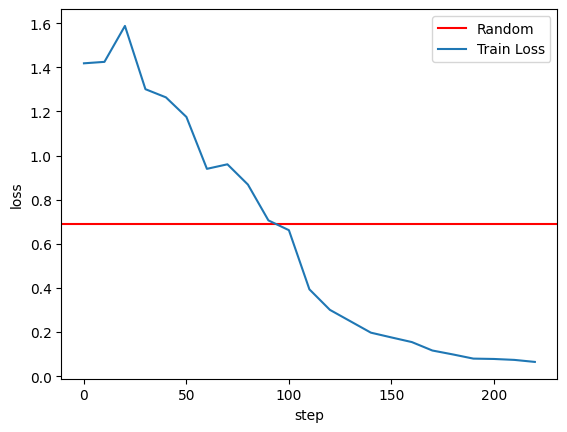

In [24]:
train_x_axis = [10*i for i in range(len(train_loss))]

plt.axhline(y=0.69, label='Random', color='red')
plt.plot(train_x_axis, train_loss, label='Train Loss')

plt.ylabel('loss')
plt.xlabel('step')

plt.legend(loc='upper right')

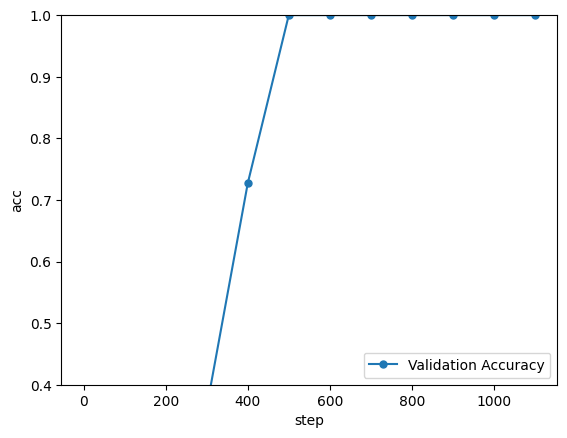

In [25]:
valid_x_axis = [100*i for i in range(len(valid_loss))]
plt.plot(valid_x_axis, valid_acc, marker='o', ms=5, label='Validation Accuracy')
plt.ylabel('acc')
plt.xlabel('step')
plt.ylim(0.4,1)
plt.legend(loc='lower right')

### Reference: 
* https://github.com/ML4SE2022/Group4
* https://github.com/zfj1998/CodeBert-Code2Text/tree/master
* https://github.com/DoojinBaek/CodeSimilarity/tree/main